In [4]:
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv

from velovi import preprocess_data, VELOVI
from scipy.sparse import issparse


In [2]:
def fit_velovi(bdata, time_dep_transcription_rate=False):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata, time_dep_transcription_rate=time_dep_transcription_rate)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    if vae.module.time_dep_transcription_rate:
        bdata.var["fit_alpha_1"] = vae.get_rates()["alpha_1"] / scaling
        bdata.var["fit_lambda_alpha"] = vae.get_rates()["lambda_alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae
def get_fit_velovi(bdata, model):
    return model.get_expression_fit(n_samples=20)
def get_alpha(t, t_switch, alpha, alpha_1, lambda_alpha):
    if isinstance(t_switch, pd.Series):
        t_switch = t_switch.values
    if isinstance(alpha, pd.Series):
        alpha = alpha.values
    if isinstance(alpha_1, pd.Series):
        alpha_1 = alpha_1.values
    if isinstance(lambda_alpha, pd.Series):
        lambda_alpha = lambda_alpha.values
    
    alpha = alpha_1 - (alpha_1 - alpha) * np.exp(-lambda_alpha * t)
    alpha[t >= t_switch] = 0

    return alpha
def get_alpha(t, t_switch, alpha, alpha_1, lambda_alpha):
    if isinstance(t_switch, pd.Series):
        t_switch = t_switch.values
    if isinstance(alpha, pd.Series):
        alpha = alpha.values
    if isinstance(alpha_1, pd.Series):
        alpha_1 = alpha_1.values
    if isinstance(lambda_alpha, pd.Series):
        lambda_alpha = lambda_alpha.values
    
    alpha = alpha_1 - (alpha_1 - alpha) * np.exp(-lambda_alpha * t)
    alpha[t >= t_switch] = 0

    return alpha
def get_state(t, alpha_0, alpha_1, lambda_alpha, beta, gamma, initial_state, t0=0):
    u0 = initial_state[0]
    s0 = initial_state[1]

    u = (
        u0 * np.exp(-beta * t)
        + alpha_1 / beta * (1 - np.exp(-beta * t))
        - (alpha_1 - alpha_0) / (beta - lambda_alpha) * np.exp(-lambda_alpha * t0) * (np.exp(-lambda_alpha * t) - np.exp(-beta * t))
    )

    s = (
        s0 * np.exp(-gamma * t)
        + alpha_1 / gamma * (1 - np.exp(-gamma * t))
        + (alpha_1  - beta * u0) / (gamma - beta) * (np.exp(-gamma * t) - np.exp(-beta * t))
        - beta * (alpha_1 - alpha_0) / (beta - lambda_alpha) / (gamma - lambda_alpha) * np.exp(-lambda_alpha * t0) * (np.exp(-lambda_alpha * t) - np.exp(-gamma * t))
        + beta * (alpha_1 - alpha_0) / (beta - lambda_alpha) / (gamma - beta) * np.exp(-lambda_alpha * t0) * (np.exp(-beta * t) - np.exp(-gamma * t))
    )

    return u, s
def get_vars(adata, key="fit"):
    alpha_0 = (
        adata.var[f"{key}_alpha"].values if f"{key}_alpha" in adata.var.keys() else 1
    )
    alpha_1 = (
        adata.var[f"{key}_alpha_1"].values if f"{key}_alpha_1" in adata.var.keys() else 0
    )
    lambda_alpha = (
        adata.var[f"{key}_lambda_alpha"].values if f"{key}_lambda_alpha" in adata.var.keys() else 0
    )
    beta = adata.var[f"{key}_beta"].values if f"{key}_beta" in adata.var.keys() else 1
    gamma = adata.var[f"{key}_gamma"].values
    t_switch = adata.var[f"{key}_t_"].values
    
    return alpha_0, alpha_1, lambda_alpha, beta, gamma, t_switch

In [3]:
def compute_dynamics(adata, basis, key="true", sort=True):
    idx = adata.var_names.get_loc(basis) if isinstance(basis, str) else basis
    key = "fit" if f"{key}_gamma" not in adata.var_keys() else key
    alpha_0, alpha_1, lambda_alpha, beta, gamma, t_switch = get_vars(adata[:, basis], key=key)
    # t = np.linspace(0, 20, 2000)  # adata.layers[f"{key}_t"][:, idx]
    
    t = adata.layers[f"latent_time_velovi"][:, idx] if key != 'true' else np.linspace(0,20,2000)
    if sort:
        t = np.sort(t)
    
    unspliced_induction, spliced_induction = get_state(
        t=t[t < t_switch],
        alpha_0=alpha_0,
        alpha_1=alpha_1,
        lambda_alpha=lambda_alpha,
        beta=beta,
        gamma=gamma,
        initial_state=[0, 0],
    )
    u0_switch, s0_switch = get_state(
        t=t_switch,
        alpha_0=alpha_0,
        alpha_1=alpha_1,
        lambda_alpha=lambda_alpha,
        beta=beta,
        gamma=gamma,
        initial_state=[0, 0],
    )
    
    unspliced_repression, spliced_repression = get_state(
        t=t[t >= t_switch] - t_switch,
        alpha_0=0,
        alpha_1=0,
        lambda_alpha=0,
        beta=beta,
        gamma=gamma,
        initial_state=[u0_switch, s0_switch],
    )
    
    unspliced = np.zeros(len(t))
    unspliced[t < t_switch] = unspliced_induction
    unspliced[t >= t_switch] = unspliced_repression
    spliced = np.zeros(len(t))
    spliced[t < t_switch] = spliced_induction
    spliced[t >= t_switch] = spliced_repression

    return unspliced, spliced
def get_rate_df(df_unspliced, df_spliced, gene):
    return pd.DataFrame(
        {
            f'unspliced': df_unspliced.loc[:, gene].values.squeeze(),
            f'spliced': df_spliced.loc[:, gene].values. squeeze(),
        }
    )

In [12]:
def plot_phase_portrait(adata, adata_true, gene, df_const_rate, df_time_dep_rate, 
                        color_data, cmap='viridis', figsize=(6, 5), save_path=None):
    """
    修改后的绘图函数，使用 plt.scatter (ax.scatter) 绘制。
    'color_data' 是一个连续的数值数组（例如 latent_time 或 n_counts）。
    """
    
    fig, ax = plt.subplots(figsize=figsize)

    def _to_1d_array(data_slice):
        if hasattr(data_slice, 'toarray'):
            data_slice = data_slice.toarray()
        arr_1d = np.asarray(data_slice).squeeze()
        if arr_1d.ndim != 1:
            raise ValueError(f"数据无法被压缩为 1D。初始形状: {data_slice.shape}, 压缩后形状: {arr_1d.shape}")
        return arr_1d

    try:
        df = pd.DataFrame(
            {
                'unspliced': _to_1d_array(adata[:, gene].layers['unspliced']).copy(),
                'spliced': _to_1d_array(adata[:, gene].layers['spliced']).copy(),
                'color_value': _to_1d_array(color_data)
            }
        )
    except Exception as e:
        print("--- 在创建 DataFrame 时出错 ---")
        print(f"Gene: {gene}")
        raise e

    try:
        idx = adata.var_names == gene
        gt_ut = adata_true.layers['unspliced'][:, idx]
        gt_st = adata_true.layers['spliced'][:, idx]
        ax.plot(gt_st , gt_ut , color='purple', linestyle='-', linewidth=8, alpha=1)
    except KeyError as e:
                print(f"警告 (基因: {gene}): 无法计算 'true' 动态。")
                print(f"  > 缺失数据: {e}。请确保 'true_alpha/beta/gamma' 在 adata.var 中,")
                print(f"    且 'true_t' 在 adata.obs 中。")
    except Exception as e:
                 print(f"计算 GT 动态时出错 (基因: {gene}): {e}")

    sc = ax.scatter(
        df['spliced'],      
        df['unspliced'],   
        c=df['color_value'], 
        cmap=cmap,            
        s=50,                 
        alpha=0.6,            
        rasterized=True      
    )

    unspliced = df_const_rate[f'unspliced']
    spliced = df_const_rate[f'spliced']
    ax.scatter(spliced, unspliced, color="#ff7f0e", s=50)
    
    unspliced = df_time_dep_rate[f'unspliced']
    spliced = df_time_dep_rate[f'spliced']
    ax.plot(spliced, unspliced, color="#ff7f0e", linestyle="--", linewidth=8)
    
    ax.axis('off')
    ax.set_title(gene)
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight', format='svg')
    plt.show()



In [15]:
adata = sc.read_h5ad('./data/adata_velovi.h5ad')
adata_true = sc.read_h5ad('./data/adata_true.h5ad')
adata_init = sc.read_h5ad('./data/adata_init.h5ad')
velovi_x_scale = adata.X.max(axis=0)
velovi_t_scale = adata.layers['fit_t'].max() / 25
bdata = adata.copy()

In [11]:
unspliced = []
spliced = []
for gene in tqdm(adata.var_names):
    _u, _s = compute_dynamics(adata, key='fit', basis=gene, sort=True)
    unspliced.append(_u.tolist())
    spliced.append(_s.tolist())
    
df_unspliced_constant = pd.DataFrame(np.array(unspliced).T, columns=adata.var_names)
df_spliced_constant = pd.DataFrame(np.array(spliced).T, columns=adata.var_names)

unspliced = []
spliced = []

for gene in tqdm(adata.var_names):
    _u, _s = compute_dynamics(bdata, key = 'fit',basis=gene, sort=True)
    unspliced.append(_u.tolist())
    spliced.append(_s.tolist())
    
df_unspliced_time_dep = pd.DataFrame(np.array(unspliced).T, columns=adata.var_names)
df_spliced_time_dep = pd.DataFrame(np.array(spliced).T, columns=adata.var_names)

100%|██████████| 60/60 [00:00<00:00, 1578.00it/s]


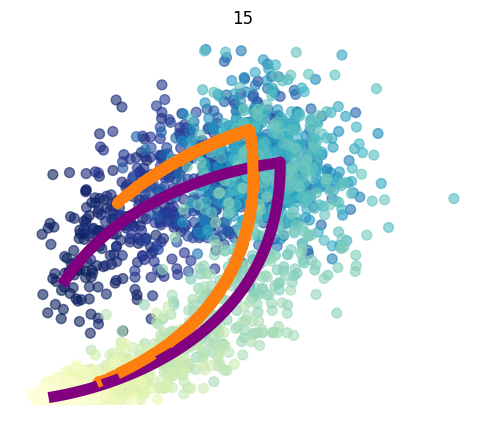

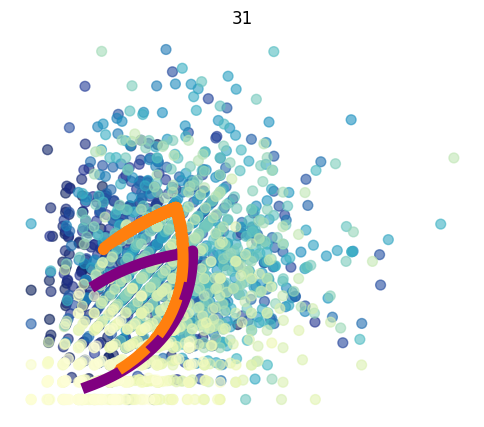

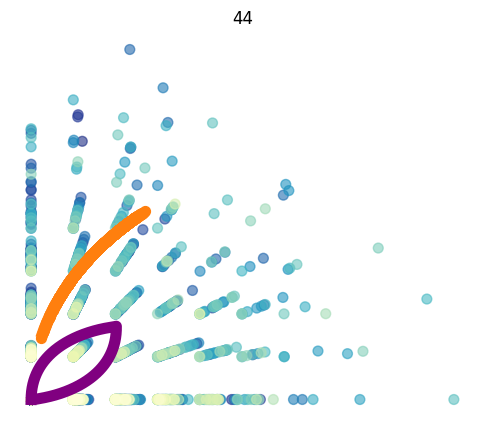

In [14]:
try:
    color_data = adata.layers["latent_time_velovi"] 
except KeyError:
    print("未找到 'latent_time_velovi'。")
    print("将回退使用 'n_counts' (总 UMI 计数) 作为颜色。")
    color_data = adata.obs['n_counts'].values

genes_to_plot = ['15', '31', '44']

for gene in genes_to_plot:


    df_const_rate = get_rate_df(
        df_unspliced=df_unspliced_constant,
        df_spliced=df_spliced_constant,
        gene=gene
    )

    df_time_dep_rate = get_rate_df(
        df_unspliced=df_unspliced_time_dep,
        df_spliced=df_spliced_time_dep,
        gene=gene
    )

    color_data_for_gene = adata.obs["true_t"]

    
    plot_phase_portrait(
        adata, 
        adata_true,
        gene=gene, 
        df_const_rate=df_const_rate, 
        df_time_dep_rate=df_time_dep_rate, 
        color_data=color_data_for_gene,  
        cmap='YlGnBu_r'           
    )